### Import data & packages

In [1]:
# Import packages
import time
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from boruta import BorutaPy
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data
df = pd.read_csv('Employee.csv')
df.head(5)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


### Exploratory data analysis

In [3]:
# Seperate categorical & numeric data
data_cols_numeric = df.select_dtypes([np.int64, np.float64]).columns
data_cols_character = df.select_dtypes(include=['object']).columns

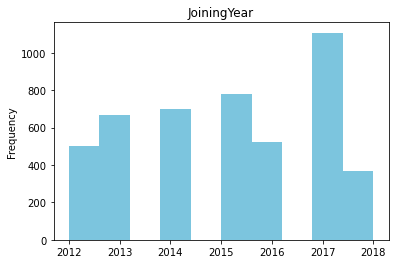

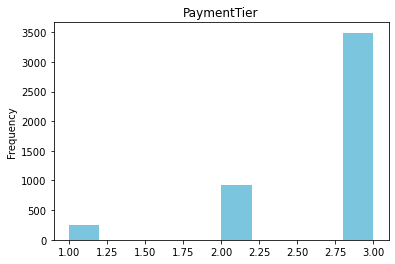

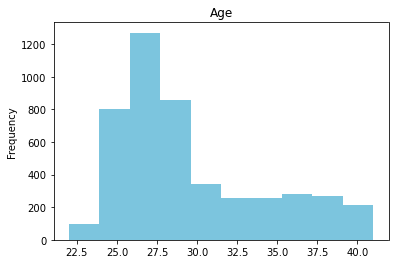

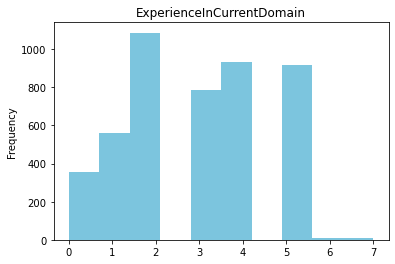

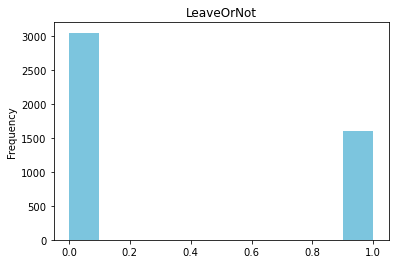

In [4]:
# Visualize all numeric columns 
for col in data_cols_numeric:
    df[col].plot.hist(title=col, color="#7cc5de")
    plt.show()

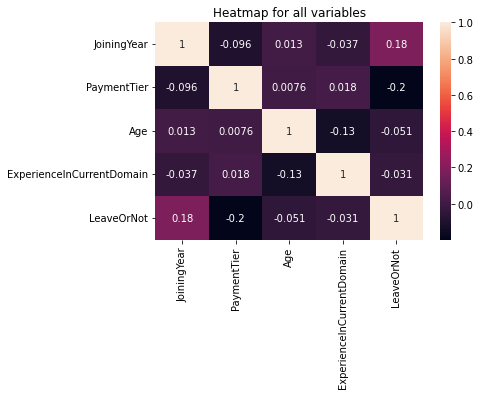

In [5]:
# Correlation plot
fig, ax = plt.subplots()    
sns.heatmap(df[data_cols_numeric].corr(), annot=True, ax=ax);
plt.title("Heatmap for all variables"); 

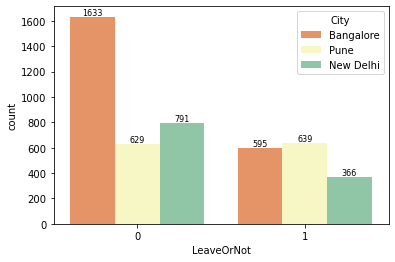

In [6]:
# Distribution of cities for employees that churn or do not churn 

plt1 = sns.countplot(x='LeaveOrNot', 
                     hue='City',
                     data=df,
                     palette="Spectral")

for i in plt1.containers:
    plt1.bar_label(i,size=8)

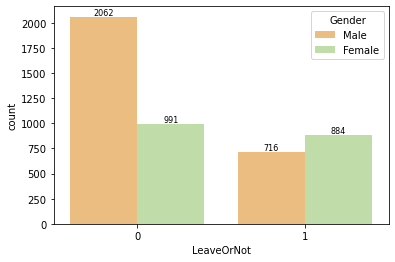

In [7]:
# Distribution of gender for employees that churn or do not churn

plt2 = sns.countplot(x='LeaveOrNot', 
                     hue='Gender',
                     data=df,
                     palette="Spectral")

for i in plt2.containers:
    plt2.bar_label(i,size=8)

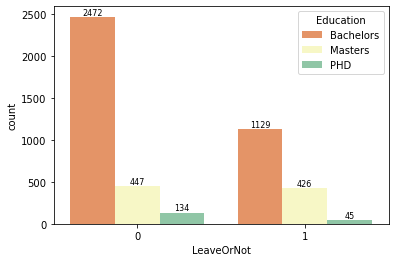

In [8]:
# Distribution of education for employees that churn or do not churn

plt3 = sns.countplot(x='LeaveOrNot', 
                     hue='Education',
                     data=df,
                     palette="Spectral")

for i in plt3.containers:
    plt3.bar_label(i,size=8)

Findings: 
- More female employees churn than male employees
- JoiningYear is positively correlated with LeaveOrNot while PaymentTier, Age and ExperienceInCurrentDomain is negatively correlated 

### Model training

In [9]:
# Train, test, validation data split
df_staging, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_staging, test_size=0.25, random_state=1)

X_train_staging = df_train.loc[:, df_train.columns[1:-1]].copy()
X_val_staging = df_val.loc[:, df_val.columns[1:-1]].copy()
X_test_staging = df_test.loc[:, df_test.columns[1:-1]].copy()

y_train = df_train.loc[:, 'LeaveOrNot']
y_val = df_val.loc[:, 'LeaveOrNot']
y_test = df_test.loc[:, 'LeaveOrNot']

In [10]:
# Encode categorical variables
dv = DictVectorizer(sparse=False)
X_train = pd.DataFrame(dv.fit_transform(X_train_staging.to_dict(orient='records')), columns=dv.get_feature_names_out())
X_val = pd.DataFrame(dv.fit_transform(X_val_staging.to_dict(orient='records')), columns=dv.get_feature_names_out())
X_test = pd.DataFrame(dv.fit_transform(X_test_staging.to_dict(orient='records')), columns=dv.get_feature_names_out())

In [11]:
# Boruta feature selection using XGB model 
xgb = XGBClassifier()

boruta = BorutaPy(xgb, n_estimators='auto', random_state=1)
boruta.fit(np.array(X_train), np.array(y_train))

selected_features = X_train.columns[boruta.support_].tolist()
print(f"Selected features: {selected_features}")

Selected features: ['City=Pune', 'EverBenched=No', 'Gender=Female', 'JoiningYear', 'PaymentTier']


In [12]:
results = {
    'Model': [],
    'Feature Selection': [],
    'F1 Score': [],
    'Percentage diff (%)': [],
    'Time Taken (s)': [],
    'Best Hyperparameters': []
}

# ML models & their hyperparameters
models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000), {'C': (0.01, 100.0, 'log-uniform'), 'random_state': [1, 42, 100, 256, 512]}),
    ('Ridge Classifier', RidgeClassifier(), {'alpha': (0.01, 100.0, 'log-uniform'), 'random_state': [1, 42, 100, 256, 512]}),
    ('Random Forest Classifier', RandomForestClassifier(), {'n_estimators': (10, 200), 'random_state': [1, 42, 100, 256, 512]}),
    ('Decision Tree Classifier', DecisionTreeClassifier(), {'max_depth': (1, 32), 'random_state': [1, 42, 100, 256, 512]}),
    ('XGBoost Classifier', XGBClassifier(verbosity=0), {'learning_rate': (0.01, 1.0, 'log-uniform'), 'n_estimators': (50, 200), 'random_state': [1, 42, 100, 256, 512]}),
    ('Neural Network Classifier', MLPClassifier(max_iter=1000), {'alpha': (0.0001, 0.1, 'log-uniform'), 'random_state': [1, 42, 100, 256, 512]})
]


feature_selection_methods = ['Boruta Feature Selection', 'Full Features']

# Train and tune the models 
for feature_selection_method in feature_selection_methods:
    if feature_selection_method == 'Boruta Feature Selection':
        selected_features = X_train.columns[boruta.support_].tolist()
        X_train_ = X_train.loc[:, selected_features].copy()
        X_test_ = X_test.loc[:, selected_features].copy()
        X_val_ = X_val.loc[:, selected_features].copy()
    else:
        X_train_ = X_train.copy()
        X_test_ = X_test.copy()
        X_val_ = X_val.copy()

    for model_name, model, param_space in models:
        start_time = time.time()

        bayes_search = BayesSearchCV(model, param_space, n_iter=20, n_jobs=-1, cv=3, scoring='f1_weighted', random_state=1)
        bayes_search.fit(X_train_, y_train)

        train_time = time.time() - start_time

        y_pred = bayes_search.predict(X_test_)
        y_pred_val = bayes_search.predict(X_val_)
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_val = f1_score(y_val, y_pred_val, average='weighted')
        train_val_diff_f1 = round((f1_val - f1) * 100, 2)

        results['Model'].append(model_name)
        results['Feature Selection'].append(feature_selection_method)
        results['F1 Score'].append(f1)
        results['Percentage diff (%)'].append(train_val_diff_f1)
        results['Time Taken (s)'].append(train_time)
        results['Best Hyperparameters'].append(bayes_search.best_params_)


C:\Users\chunh\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\chunh\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [13]:
# View output 
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=True)
results_df

,Model,Feature Selection,F1 Score,Percentage diff (%),Time Taken (s),Best Hyperparameters
5,Neural Network Classifier,Boruta Feature Selection,0.200386,-4.06,11.725361,"{'alpha': 0.012821386062062406, 'random_state'..."
11,Neural Network Classifier,Full Features,0.666635,3.74,12.253017,"{'alpha': 0.0009260248057520602, 'random_state..."
1,Ridge Classifier,Boruta Feature Selection,0.668311,2.39,6.342736,"{'alpha': 3.970742395266713, 'random_state': 1}"
0,Logistic Regression,Boruta Feature Selection,0.670963,2.60,10.476599,"{'C': 74.17596170159602, 'random_state': 100}"
6,Logistic Regression,Full Features,0.676038,3.30,7.506152,"{'C': 9.117119119604657, 'random_state': 1}"
7,Ridge Classifier,Full Features,0.681810,1.84,6.567730,"{'alpha': 0.02923553521649806, 'random_state':..."
8,Random Forest Classifier,Full Features,0.799145,-0.41,14.545199,"{'n_estimators': 185, 'random_state': 512}"
2,Random Forest Classifier,Boruta Feature Selection,0.810566,1.54,9.841571,"{'n_estimators': 10, 'random_state': 512}"
9,Decision Tree Classifier,Full Features,0.812721,2.09,7.726750,"{'max_depth': 6, 'random_state': 512}"
3,Decision Tree Classifier,Boruta Feature Selection,0.817867,1.91,6.491188,"{'max_depth': 6, 'random_state': 256}"


Decision Tree Classifier (Boruta Feature Selection) is selected as: 
- Using lesser deatures (Boruta Feature Selection) returns around the same F1-score with full features 
- Has a lesser percentage difference for test and validation F1-score than XGBoost Classifier
- A high F1-score of 0.818 suggests the model is achieving a good balance between making accurate positive predictions and not missing too many actual positive cases

### Model selection & export

In [14]:
# Train the selected champion model 
hyperparameters = {
    'max_depth': 6,
    'random_state': 256
}

dt_classifier = DecisionTreeClassifier(**hyperparameters)
dt_classifier.fit(X_train.loc[:, selected_features], y_train)

y_pred = dt_classifier.predict(X_test.loc[:, selected_features])
y_pred_val = dt_classifier.predict(X_val.loc[:, selected_features])
dt_classifier.fit(X_train.loc[:, selected_features], y_train)

y_pred = dt_classifier.predict(X_test.loc[:, selected_features])
y_pred_val = dt_classifier.predict(X_val.loc[:, selected_features])

f1 = f1_score(y_test, y_pred, average='weighted')
f1_val = f1_score(y_val, y_pred_val, average='weighted')
print(f"F1 test score: {f1:.2f}\nF1 test valid score: {f1_val:.2f}")

F1 test score: 0.82
F1 test valid score: 0.84


In [15]:
# Fit transform dictvectorizer (using features that has been selected via boruta feature selection)
dv_export = DictVectorizer(sparse=False)
dv_export.fit_transform(X_train.loc[:, selected_features].to_dict(orient='records'))

array([[1.000e+00, 0.000e+00, 1.000e+00, 2.015e+03, 2.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, 2.013e+03, 3.000e+00],
       [1.000e+00, 1.000e+00, 1.000e+00, 2.015e+03, 2.000e+00],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, 2.015e+03, 3.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, 2.017e+03, 3.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, 2.014e+03, 3.000e+00]])

In [16]:
# Export models & dictvectorizer
joblib.dump(dv_export, 'dv.bin')
joblib.dump(dt_classifier, 'model.bin')

['model.bin']